# **Convolutional neural networks for image classification**

</hr>

## The notebook contents implementation of image classification using different CNN models: self-written & pretrained, using data Intel Image Classification.


## **About dataset:**
### **Context**
### **This is image data of Natural Scenes around the world.**

## **Content**

###This Data contains around 25k images of size 150x150 distributed under 6 categories.

* 'buildings' -> 0
* 'forest' -> 1
* 'glacier' -> 2
* 'mountain' -> 3
* 'sea' -> 4
* 'street' -> 5

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

## **Acknowledgements**
* Thanks to https://datahack.analyticsvidhya.com for the challenge and Intel for the Data
* source: https://www.kaggle.com/datasets/puneet6060/intel-image-classification


[==================================================] 363152213 bytes downloaded
Downloaded and uncompressed: intel-image-classification
Data source import complete.


In [2]:
!pip install torchviz
!pip install torchinfo

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

# Imports

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(font_scale=1.5)
import os
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation
from torchviz import make_dot

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve
from tqdm import tqdm
import cv2


# Data loading

In [4]:
class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
class_num = len(class_names)
IMG_SIZE = (256, 256)


In [51]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """

    datasets = ['/kaggle/input/intel-image-classification/seg_train/seg_train', '/kaggle/input/intel-image-classification/seg_test/seg_test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMG_SIZE)

                # Convert image to uint8
                image = image.astype(np.uint8)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype='uint8')
        labels = np.array(labels, dtype='int64')

        output.append((images, labels))

    return output

In [52]:
(X_train, y_train), (X_test, y_test) = load_data()
print("Number of train images", X_train.shape)
print("Number of test images", X_test.shape)
print("Number of train labels", y_train.shape)
print("Number of test labels", y_test.shape)

Loading /kaggle/input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:02<00:00, 1074.03it/s]


Loading /kaggle/input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:00<00:00, 788.19it/s]


Number of train images (14034, 256, 256, 3)
Number of test images (3000, 256, 256, 3)
Number of train labels (14034,)
Number of test labels (3000,)


# Creation of custom dataset

In [53]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision.transforms import RandomHorizontalFlip, RandomRotation


class convert_to_rgb(object):
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img

class CustomDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.labels = labels
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)

        if self.transforms:
            img = self.transforms(img)

        if self.labels is not None:
            label = self.labels[index]
            return img, label
        else:
            return img



train_transforms = transforms.Compose([
    convert_to_rgb(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    convert_to_rgb(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_data = CustomDataset(X_train, labels=y_train, transforms=train_transforms)
test_data = CustomDataset(X_test, labels=y_test, transforms=test_transforms)

BS = 32


trainLoader = DataLoader(train_data, batch_size=BS, shuffle=True)
testLoader = DataLoader(test_data, batch_size=BS, shuffle=False)

In [54]:
img, label = train_data[0]
print(f"img.shape={img.shape} (channels, height, width)")
print(f"label={label}")

img.shape=torch.Size([3, 256, 256]) (channels, height, width)
label=0


# Example of image from train data.

Batch shape: torch.Size([32, 3, 256, 256]), torch.Size([32])
Image shape: torch.Size([3, 256, 256]), Label: 1


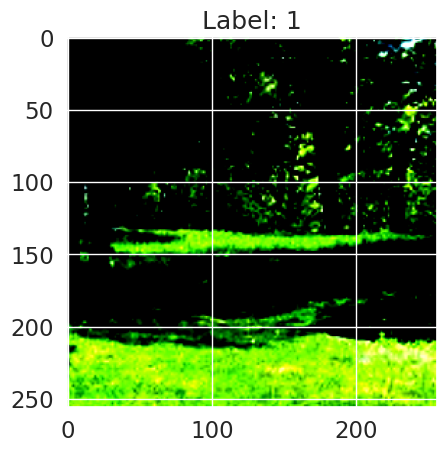

In [55]:
for images, labels in trainLoader:
    print(f"Batch shape: {images.shape}, {labels.shape}")

    img, label = images[0], labels[0]
    print(f"Image shape: {img.shape}, Label: {label}")
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(f"Label: {label}")
    plt.show()

    break

# Example of image from test data.

Batch shape: torch.Size([32, 3, 256, 256]), torch.Size([32])
Image shape: torch.Size([3, 256, 256]), Label: 0


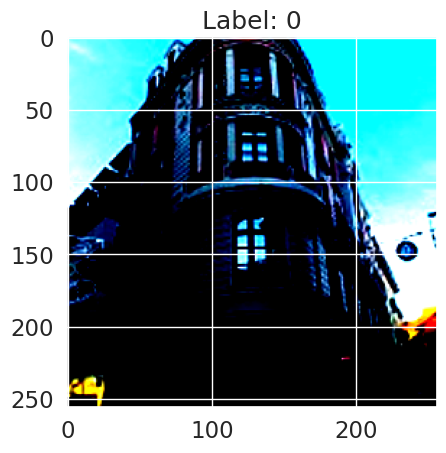

In [56]:
for images, labels in testLoader:
    print(f"Batch shape: {images.shape}, {labels.shape}")

    img, label = images[-1], labels[-1]
    print(f"Image shape: {img.shape}, Label: {label}")
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(f"Label: {label}")
    plt.show()

    break

# Plain 3-Layer model for classification

### Early stopping function for overfitting prevention

In [26]:
if torch.cuda.is_available():
  device = "cuda"
else:
   device = "cpu"

print(f"Using {device} device")

Using cuda device


In [27]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

        return self.early_stop

    def save_checkpoint(self, val_loss):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'\tValidation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss


In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, class_num)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(x)

        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool(x)

        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(x)

        x = x.view(-1, 128 * 32 * 32)

        x = self.bn4(F.relu(self.fc1(x)))
        x = self.dropout(x)

        x = self.bn5(F.relu(self.fc2(x)))
        x = self.dropout(x)

        x = self.fc3(x)
        res = F.log_softmax(x, dim=1)
        return res

In [29]:
model = CNN()

summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 6]                    --
├─Conv2d: 1-1                            [1, 32, 256, 256]         896
├─BatchNorm2d: 1-2                       [1, 32, 256, 256]         64
├─MaxPool2d: 1-3                         [1, 32, 128, 128]         --
├─Conv2d: 1-4                            [1, 64, 128, 128]         18,496
├─BatchNorm2d: 1-5                       [1, 64, 128, 128]         128
├─MaxPool2d: 1-6                         [1, 64, 64, 64]           --
├─Conv2d: 1-7                            [1, 128, 64, 64]          73,856
├─BatchNorm2d: 1-8                       [1, 128, 64, 64]          256
├─MaxPool2d: 1-9                         [1, 128, 32, 32]          --
├─Linear: 1-10                           [1, 256]                  33,554,688
├─BatchNorm1d: 1-11                      [1, 256]                  512
├─Dropout: 1-12                          [1, 256]                

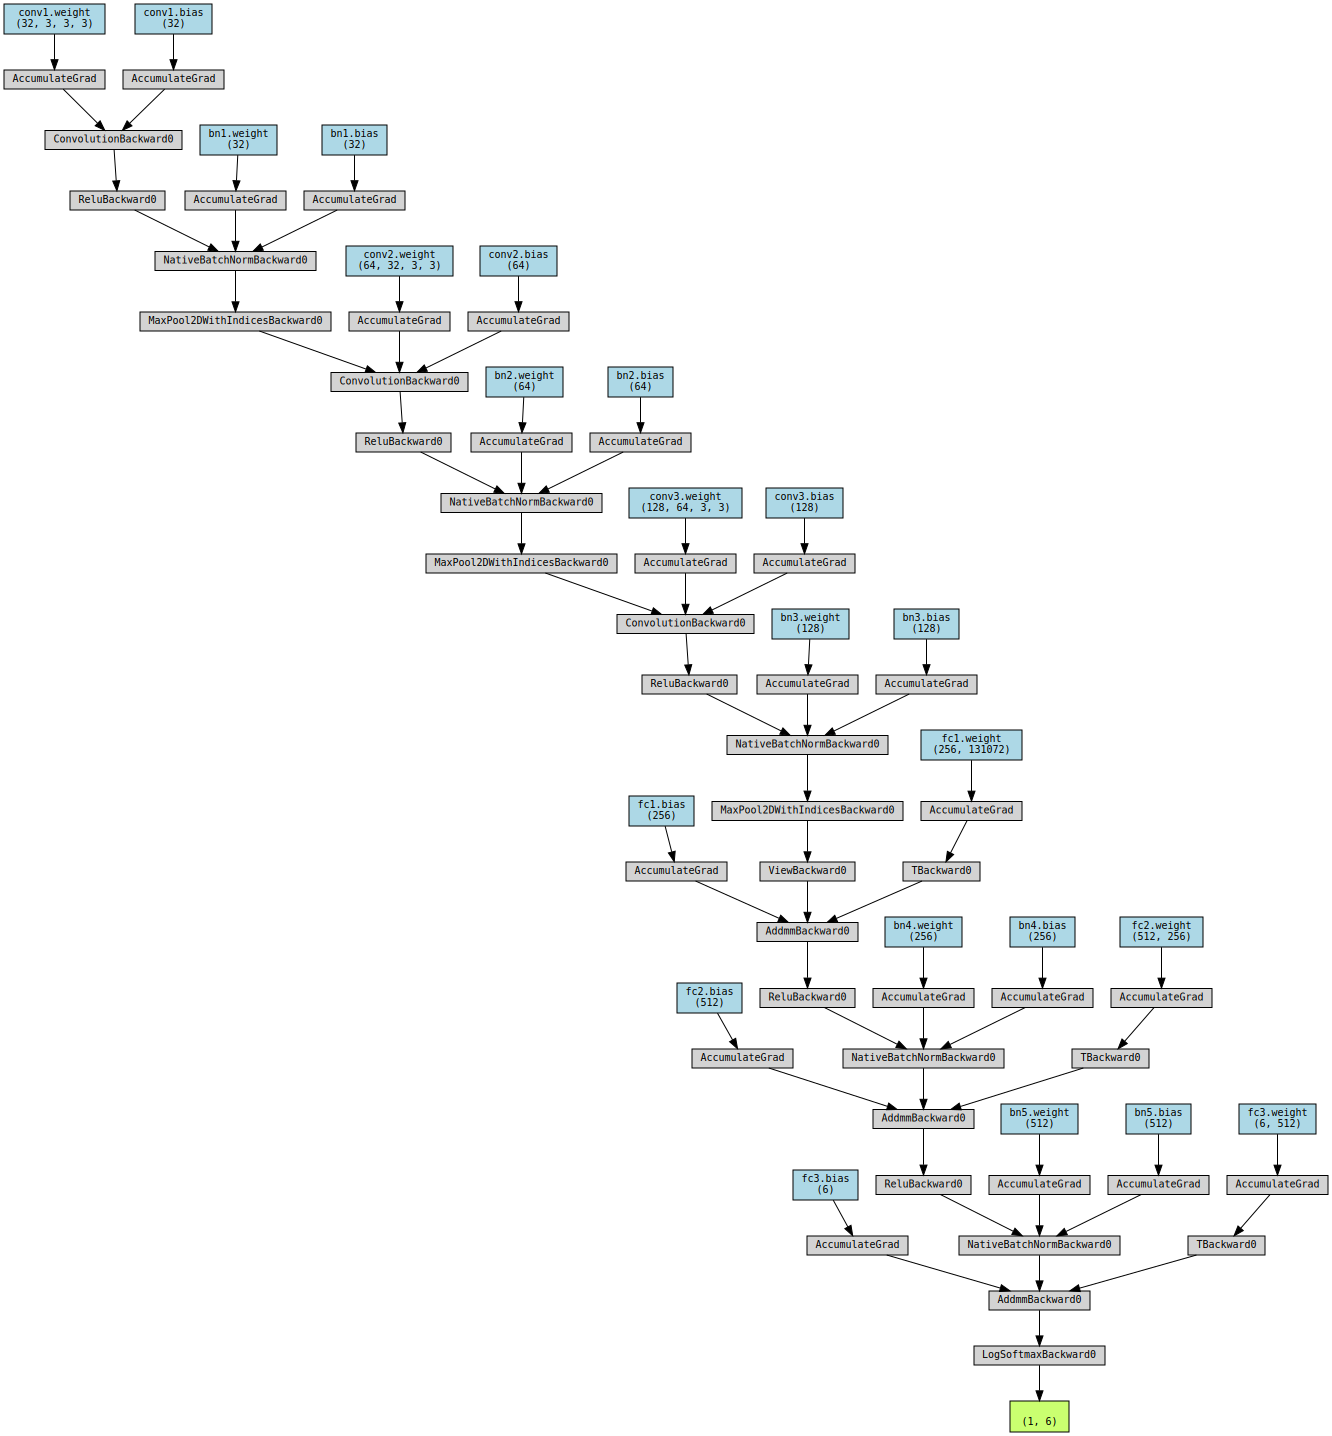

In [30]:
model = CNN()
model.eval()

dummy_input = torch.randn(1, 3, 256, 256)
model_viz = make_dot(model(dummy_input), params=dict(model.named_parameters()))
model_viz.render("cnn_model_architecture", format="png")
model_viz

In [57]:
def train(train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs, early_stopping):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    train_truth_labels = []
    train_predicted_labels = []
    test_truth_labels = []
    test_predicted_labels = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        train_truth = []
        train_predicted = []

        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

            train_truth.extend(targets.cpu().numpy())
            train_predicted.extend(predicted.cpu().numpy())

        train_accuracy = correct_train / total_train
        train_losses.append(train_loss / len(train_dataloader))
        train_accuracies.append(train_accuracy)
        train_truth_labels.extend(train_truth)
        train_predicted_labels.extend(train_predicted)
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        test_truth = []
        test_predicted = []

        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_test += targets.size(0)
                correct_test += (predicted == targets).sum().item()

                test_truth.extend(targets.cpu().numpy())
                test_predicted.extend(predicted.cpu().numpy())

        test_accuracy = correct_test / total_test
        test_losses.append(test_loss / len(test_dataloader))
        test_accuracies.append(test_accuracy)
        test_truth_labels.extend(test_truth)
        test_predicted_labels.extend(test_predicted)

        print(f"Epoch [{epoch + 1}/{num_epochs}], ")
        print(f"\tTrain Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, ")
        print(f"\tTest Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.4f}")

        if early_stopping is not None:
            if early_stopping(test_losses[-1]):
                print("Early stopping")
                break


    results_resnet = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'test_accuracy': test_accuracies,
        'train_accuracy': train_accuracies,
        'train_predicted_labels': train_predicted_labels,
        'train_truth_labels': train_truth_labels,
        'test_predicted_labels': test_predicted_labels,
        'test_truth_labels': test_truth_labels
    }

    torch.save(results_resnet, 'results_cnn.pth')

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.show()


# 3-layer CNN with learning rate (lr=0.0001)

Epoch [1/50], 
	Train Loss: 0.9705, Train Accuracy: 0.6325, 
	Test Loss: 0.6729, Test Accuracy: 0.7603
	Validation loss decreased (inf --> 0.672858).  Saving model ...
Epoch [2/50], 
	Train Loss: 0.6984, Train Accuracy: 0.7474, 
	Test Loss: 0.5759, Test Accuracy: 0.8073
	Validation loss decreased (0.672858 --> 0.575943).  Saving model ...
Epoch [3/50], 
	Train Loss: 0.5884, Train Accuracy: 0.7886, 
	Test Loss: 0.5071, Test Accuracy: 0.8193
	Validation loss decreased (0.575943 --> 0.507081).  Saving model ...
Epoch [4/50], 
	Train Loss: 0.5269, Train Accuracy: 0.8122, 
	Test Loss: 0.5365, Test Accuracy: 0.8260
EarlyStopping counter: 1 out of 3
Epoch [5/50], 
	Train Loss: 0.4686, Train Accuracy: 0.8325, 
	Test Loss: 0.4783, Test Accuracy: 0.8270
	Validation loss decreased (0.507081 --> 0.478320).  Saving model ...
Epoch [6/50], 
	Train Loss: 0.3932, Train Accuracy: 0.8616, 
	Test Loss: 0.4720, Test Accuracy: 0.8410
	Validation loss decreased (0.478320 --> 0.471953).  Saving model ...
Epo

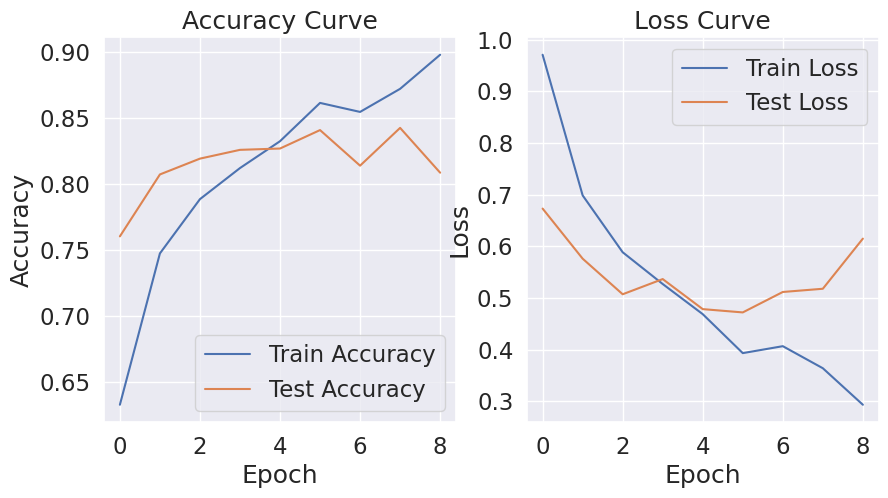

In [58]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
early_stopping = EarlyStopping(patience=3, verbose=True)

train(trainLoader, testLoader, model, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping)


# 3-layer CNN with learning rate (lr=0.001)

Epoch [1/50], 
	Train Loss: 0.8730, Train Accuracy: 0.6722, 
	Test Loss: 0.6702, Test Accuracy: 0.7453
	Validation loss decreased (inf --> 0.670214).  Saving model ...
Epoch [2/50], 
	Train Loss: 0.6106, Train Accuracy: 0.7805, 
	Test Loss: 0.5354, Test Accuracy: 0.8057
	Validation loss decreased (0.670214 --> 0.535433).  Saving model ...
Epoch [3/50], 
	Train Loss: 0.5306, Train Accuracy: 0.8127, 
	Test Loss: 0.4678, Test Accuracy: 0.8273
	Validation loss decreased (0.535433 --> 0.467763).  Saving model ...
Epoch [4/50], 
	Train Loss: 0.5098, Train Accuracy: 0.8188, 
	Test Loss: 0.4895, Test Accuracy: 0.8193
EarlyStopping counter: 1 out of 5
Epoch [5/50], 
	Train Loss: 0.4582, Train Accuracy: 0.8345, 
	Test Loss: 0.4249, Test Accuracy: 0.8540
	Validation loss decreased (0.467763 --> 0.424859).  Saving model ...
Epoch [6/50], 
	Train Loss: 0.3807, Train Accuracy: 0.8649, 
	Test Loss: 0.4548, Test Accuracy: 0.8343
EarlyStopping counter: 1 out of 5
Epoch [7/50], 
	Train Loss: 0.3406, Tra

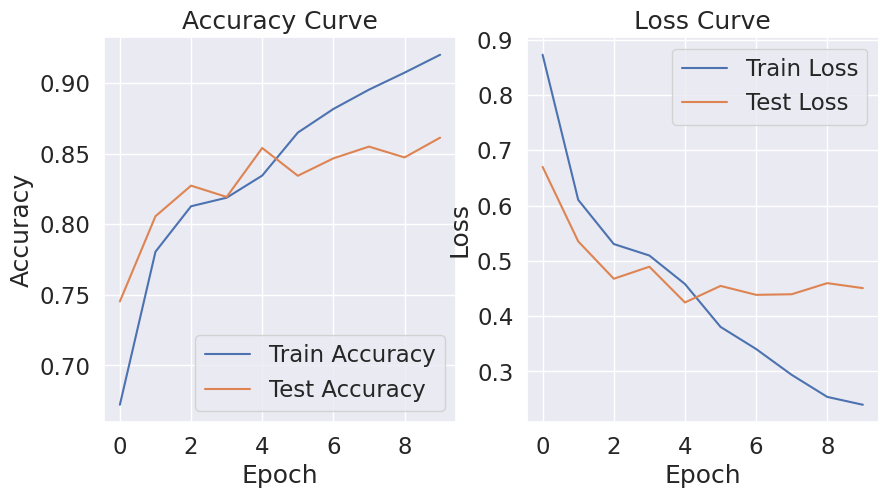

In [60]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, verbose=True)

train(trainLoader, testLoader, model, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping)


# ResNet (Frozen & fine Tuned)

In [62]:
from torchvision import datasets, transforms, models

def initialize_resnet(num_classes, use_pretrained=True, freeze=False):
    def freeze_model(model_conv):
        for param in model_conv.parameters():
            param.requires_grad=False

    model_conv = models.resnet18(weights='ResNet18_Weights.DEFAULT' if use_pretrained else None)
    if freeze:
        freeze_model(model_conv)
    num_features = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_features, num_classes)
    model_conv.to(device)
    return model_conv


In [66]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def train_torchvision_models(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, freeze=False):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_truth_labels = []
    train_predicted_labels = []
    val_truth_labels = []
    val_predicted_labels = []
    early_stopping = EarlyStopping(patience=3, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        train_truth = []
        train_predicted = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            train_truth.extend(labels.cpu().numpy())
            train_predicted.extend(predicted_train.cpu().numpy())

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_truth_labels.extend(train_truth)
        train_predicted_labels.extend(train_predicted)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_truth = []
        val_predicted = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted_val = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

                val_truth.extend(labels.cpu().numpy())
                val_predicted.extend(predicted_val.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_truth_labels.extend(val_truth)
        val_predicted_labels.extend(val_predicted)

        print(f'Epoch [{epoch + 1}/{num_epochs}], ')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, ')
        print(f' Test Loss: {val_loss:.4f},  Test Accuracy: {val_accuracy:.4f}')

        if early_stopping(val_loss):
            print("Early stopping")
            break


    results_resnet = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies,
        'train_accuracy': train_accuracies,
        'train_predicted_labels': train_predicted_labels,
        'train_truth_labels': train_truth_labels,
        'val_predicted_labels': val_predicted_labels,
        'val_truth_labels': val_truth_labels
    }
    if freeze==False:
          torch.save(results_resnet, "resnet_tuned_model.pth")
    else:
          torch.save(results_resnet, "resnet_freeze_model.pth")


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()

    plt.show()


cuda
Epoch [1/50], 
Train Loss: 0.4862, Train Accuracy: 0.8418, 
 Test Loss: 0.2983,  Test Accuracy: 0.8957
	Validation loss decreased (inf --> 0.298294).  Saving model ...
Epoch [2/50], 
Train Loss: 0.3091, Train Accuracy: 0.8903, 
 Test Loss: 0.2692,  Test Accuracy: 0.9020
	Validation loss decreased (0.298294 --> 0.269180).  Saving model ...
Epoch [3/50], 
Train Loss: 0.2786, Train Accuracy: 0.8995, 
 Test Loss: 0.2631,  Test Accuracy: 0.9007
	Validation loss decreased (0.269180 --> 0.263130).  Saving model ...
Epoch [4/50], 
Train Loss: 0.2712, Train Accuracy: 0.9052, 
 Test Loss: 0.2506,  Test Accuracy: 0.9063
	Validation loss decreased (0.263130 --> 0.250569).  Saving model ...
Epoch [5/50], 
Train Loss: 0.2646, Train Accuracy: 0.9017, 
 Test Loss: 0.2664,  Test Accuracy: 0.9060
EarlyStopping counter: 1 out of 3
Epoch [6/50], 
Train Loss: 0.2574, Train Accuracy: 0.9086, 
 Test Loss: 0.2469,  Test Accuracy: 0.9057
	Validation loss decreased (0.250569 --> 0.246866).  Saving model ..

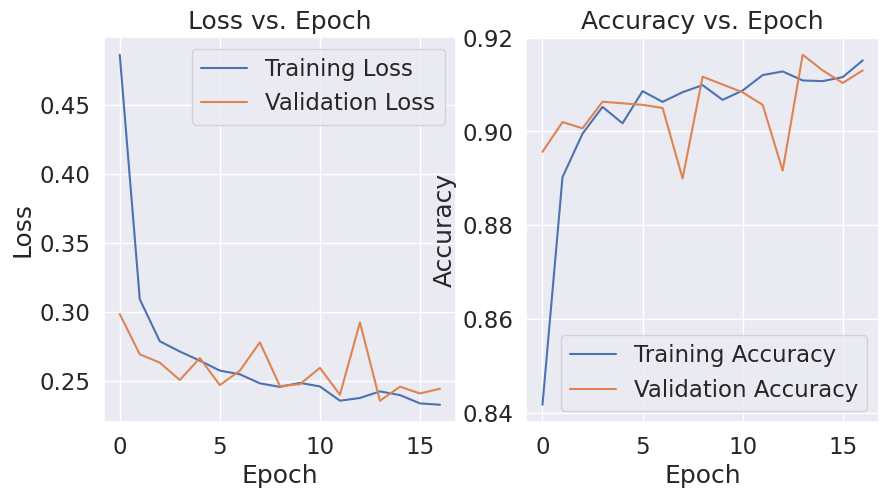

In [67]:
resnet_froze_model = initialize_resnet(num_classes=class_num, use_pretrained=True, freeze=True)
print(device)
resnet_froze_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_froze_model.parameters(), lr=0.001)

train_torchvision_models(resnet_froze_model, trainLoader, testLoader, criterion, optimizer, freeze=True)

## Pretrained FineTuned ResNet18

In [ ]:
resnet_tuned_model = initialize_resnet(num_classes=class_num, use_pretrained=True, freeze=False)
resnet_tuned_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_tuned_model.parameters(), lr=0.0001)

train_torchvision_models(resnet_tuned_model, trainLoader, testLoader, criterion, optimizer, freeze=False)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/50], 
Train Loss: 0.2833, Train Accuracy: 0.9025, 
 Test Loss: 0.2051,  Test Accuracy: 0.9230
	Validation loss decreased (inf --> 0.205055).  Saving model ...
Epoch [2/50], 
Train Loss: 0.1650, Train Accuracy: 0.9432, 
 Test Loss: 0.1935,  Test Accuracy: 0.9317
	Validation loss decreased (0.205055 --> 0.193529).  Saving model ...
Epoch [3/50], 
Train Loss: 0.1177, Train Accuracy: 0.9590, 
 Test Loss: 0.2076,  Test Accuracy: 0.9247
EarlyStopping counter: 1 out of 3
Epoch [4/50], 
Train Loss: 0.0835, Train Accuracy: 0.9720, 
 Test Loss: 0.2225,  Test Accuracy: 0.9343
EarlyStopping counter: 2 out of 3
Epoch [5/50], 
Train Loss: 0.0605, Train Accuracy: 0.9801, 
 Test Loss: 0.2157,  Test Accuracy: 0.9377
EarlyStopping counter: 3 out of 3
Early stopping


## AlexNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 154MB/s]


Epoch [1/50], 
Train Loss: 1.1192, Train Accuracy: 0.5938, 
 Test Loss: 1.0458,  Test Accuracy: 0.6560
	Validation loss decreased (inf --> 1.045804).  Saving model ...
Epoch [2/50], 
Train Loss: 0.6805, Train Accuracy: 0.7578, 
 Test Loss: 0.6293,  Test Accuracy: 0.7800
	Validation loss decreased (1.045804 --> 0.629300).  Saving model ...
Epoch [3/50], 
Train Loss: 0.6165, Train Accuracy: 0.7916, 
 Test Loss: 0.5178,  Test Accuracy: 0.8137
	Validation loss decreased (0.629300 --> 0.517839).  Saving model ...
Epoch [4/50], 
Train Loss: 0.6298, Train Accuracy: 0.7805, 
 Test Loss: 0.5339,  Test Accuracy: 0.8180
EarlyStopping counter: 1 out of 3
Epoch [5/50], 
Train Loss: 0.5600, Train Accuracy: 0.8078, 
 Test Loss: 0.4539,  Test Accuracy: 0.8417
	Validation loss decreased (0.517839 --> 0.453928).  Saving model ...
Epoch [6/50], 
Train Loss: 0.5141, Train Accuracy: 0.8278, 
 Test Loss: 0.4734,  Test Accuracy: 0.8400
EarlyStopping counter: 1 out of 3
Epoch [7/50], 
Train Loss: 0.4911, Trai

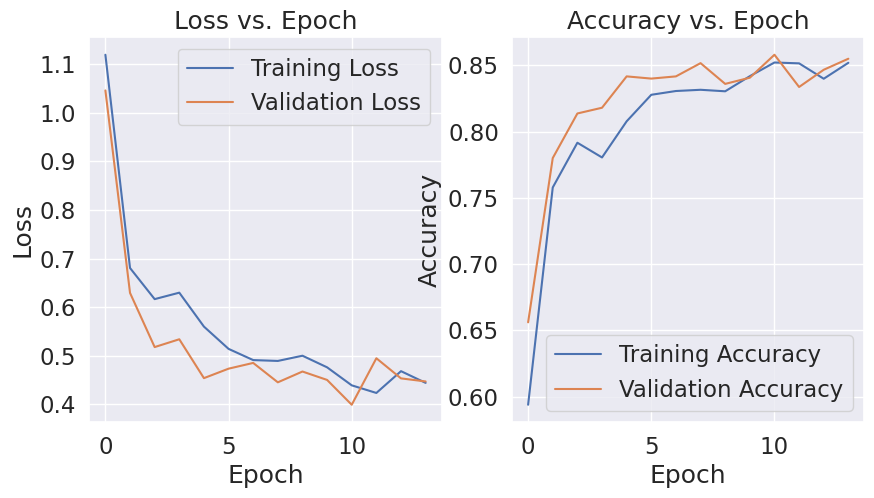

In [76]:
import torchvision
alexnet_tuned_model = torchvision.models.alexnet(pretrained=True)
alexnet_tuned_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_tuned_model.parameters(), lr=0.0001)

train_torchvision_models(alexnet_tuned_model, trainLoader, testLoader, criterion, optimizer, freeze=False)

## ResNet101

In [ ]:
import torchvision
resnet101_tuned_model = torchvision.models.resnet101(pretrained=True)
resnet101_tuned_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet101_tuned_model.parameters(), lr=0.0001)

train_torchvision_models(resnet101_tuned_model, trainLoader, testLoader, criterion, optimizer, freeze=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 120MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed

Epoch [1/50], 
Train Loss: 0.4027, Train Accuracy: 0.8909, 
 Test Loss: 0.2042,  Test Accuracy: 0.9283
	Validation loss decreased (inf --> 0.204186).  Saving model ...
Epoch [2/50], 
Train Loss: 0.1849, Train Accuracy: 0.9331, 
 Test Loss: 0.1958,  Test Accuracy: 0.9273
	Validation loss decreased (0.204186 --> 0.195806).  Saving model ...
Epoch [3/50], 
Train Loss: 0.1479, Train Accuracy: 0.9482, 
 Test Loss: 0.1969,  Test Accuracy: 0.9283
EarlyStopping counter: 1 out of 3
Epoch [4/50], 
Train Loss: 0.1146, Train Accuracy: 0.9613, 
 Test Loss: 0.2305,  Test Accuracy: 0.9237
EarlyStopping counter: 2 out of 3
Epoch [5/50], 
Train Loss: 0.0891, Train Accuracy: 0.9689, 
 Test Loss: 0.2303,  Test Accuracy: 0.9327
EarlyStopping counter: 3 out of 3
Early stopping


## SqueezeNet1_1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 27.2MB/s]


Epoch [1/50], 
Train Loss: 0.6074, Train Accuracy: 0.8048, 
 Test Loss: 0.3372,  Test Accuracy: 0.8793
	Validation loss decreased (inf --> 0.337245).  Saving model ...
Epoch [2/50], 
Train Loss: 0.2926, Train Accuracy: 0.8979, 
 Test Loss: 0.2586,  Test Accuracy: 0.9067
	Validation loss decreased (0.337245 --> 0.258615).  Saving model ...
Epoch [3/50], 
Train Loss: 0.2471, Train Accuracy: 0.9133, 
 Test Loss: 0.3176,  Test Accuracy: 0.8890
EarlyStopping counter: 1 out of 3
Epoch [4/50], 
Train Loss: 0.2267, Train Accuracy: 0.9219, 
 Test Loss: 0.2733,  Test Accuracy: 0.9050
EarlyStopping counter: 2 out of 3
Epoch [5/50], 
Train Loss: 0.1999, Train Accuracy: 0.9310, 
 Test Loss: 0.2401,  Test Accuracy: 0.9160
	Validation loss decreased (0.258615 --> 0.240150).  Saving model ...
Epoch [6/50], 
Train Loss: 0.1961, Train Accuracy: 0.9302, 
 Test Loss: 0.2540,  Test Accuracy: 0.9123
EarlyStopping counter: 1 out of 3
Epoch [7/50], 
Train Loss: 0.1750, Train Accuracy: 0.9361, 
 Test Loss: 0.2

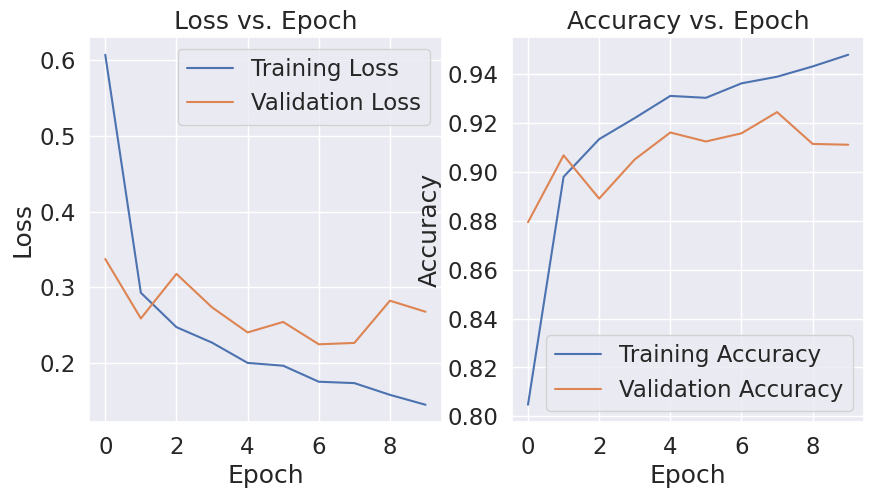

In [78]:
squeezenet_tuned_model = torchvision.models.squeezenet1_1(pretrained=True)
squeezenet_tuned_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(squeezenet_tuned_model.parameters(), lr=0.0001)

train_torchvision_models(squeezenet_tuned_model, trainLoader, testLoader, criterion, optimizer, freeze=False)

## DenseNet121

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 38.5MB/s]


Epoch [1/50], 
Train Loss: 0.5026, Train Accuracy: 0.8804, 
 Test Loss: 0.2140,  Test Accuracy: 0.9283
	Validation loss decreased (inf --> 0.214015).  Saving model ...
Epoch [2/50], 
Train Loss: 0.1730, Train Accuracy: 0.9400, 
 Test Loss: 0.2006,  Test Accuracy: 0.9293
	Validation loss decreased (0.214015 --> 0.200575).  Saving model ...
Epoch [3/50], 
Train Loss: 0.1178, Train Accuracy: 0.9585, 
 Test Loss: 0.2078,  Test Accuracy: 0.9297
EarlyStopping counter: 1 out of 3
Epoch [4/50], 
Train Loss: 0.0897, Train Accuracy: 0.9689, 
 Test Loss: 0.2103,  Test Accuracy: 0.9303
EarlyStopping counter: 2 out of 3
Epoch [5/50], 
Train Loss: 0.0639, Train Accuracy: 0.9788, 
 Test Loss: 0.2186,  Test Accuracy: 0.9323
EarlyStopping counter: 3 out of 3
Early stopping


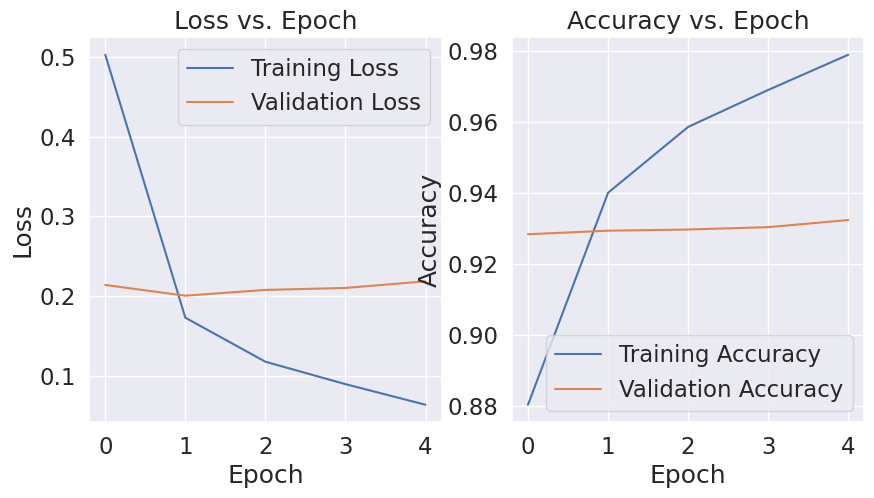

In [79]:
densenet_tuned_model = torchvision.models.densenet121(pretrained=True)
densenet_tuned_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_tuned_model.parameters(), lr=0.0001)

train_torchvision_models(densenet_tuned_model, trainLoader, testLoader, criterion, optimizer, freeze=False)

## MobileNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 35.6MB/s]


Epoch [1/50], 
Train Loss: 0.5045, Train Accuracy: 0.8763, 
 Test Loss: 0.2236,  Test Accuracy: 0.9220
	Validation loss decreased (inf --> 0.223616).  Saving model ...
Epoch [2/50], 
Train Loss: 0.2011, Train Accuracy: 0.9334, 
 Test Loss: 0.2189,  Test Accuracy: 0.9173
	Validation loss decreased (0.223616 --> 0.218905).  Saving model ...
Epoch [3/50], 
Train Loss: 0.1607, Train Accuracy: 0.9429, 
 Test Loss: 0.2112,  Test Accuracy: 0.9280
	Validation loss decreased (0.218905 --> 0.211249).  Saving model ...
Epoch [4/50], 
Train Loss: 0.1206, Train Accuracy: 0.9573, 
 Test Loss: 0.2061,  Test Accuracy: 0.9347
	Validation loss decreased (0.211249 --> 0.206149).  Saving model ...
Epoch [5/50], 
Train Loss: 0.0899, Train Accuracy: 0.9685, 
 Test Loss: 0.2149,  Test Accuracy: 0.9283
EarlyStopping counter: 1 out of 3
Epoch [6/50], 
Train Loss: 0.0805, Train Accuracy: 0.9714, 
 Test Loss: 0.2540,  Test Accuracy: 0.9260
EarlyStopping counter: 2 out of 3
Epoch [7/50], 
Train Loss: 0.0648, Trai

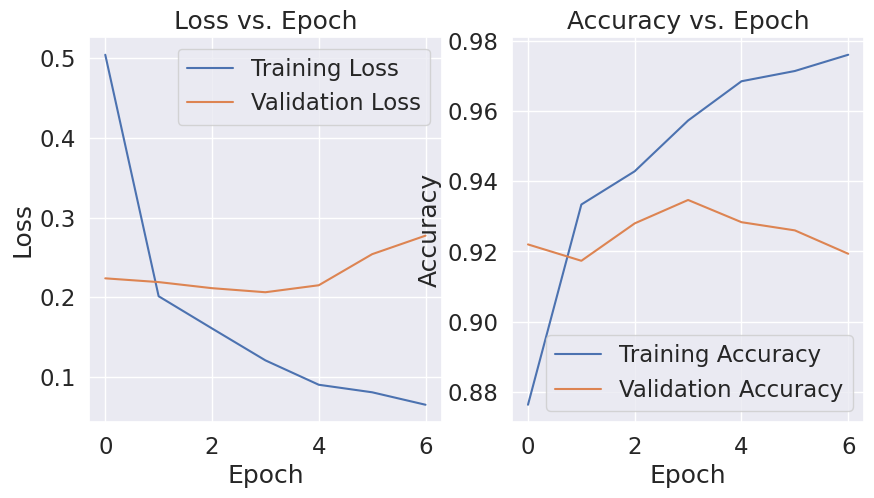

In [80]:
mobilenet_tuned_model = torchvision.models.mobilenet_v2(pretrained=True)
mobilenet_tuned_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_tuned_model.parameters(), lr=0.0001)

train_torchvision_models(mobilenet_tuned_model, trainLoader, testLoader, criterion, optimizer, freeze=False)

# Results

## Here are final results for each model (only for test data)


| **Model**                          | Final Loss| Final accuracy   |
|------------------------------------|-----------|------------------|
| Plain 3-layer CNN       (lr=0.0001)| 0.6147    | 0.8087           |
| Plain 3-layer CNN       (lr=0.001) | 0.4508    | 0.8613           |
| Frozen ResNet           (lr=0.0001)| 0.2443    | 0.9130           |
| FineTuned ResNet        (lr=0.0001)| 0.2157    | 0.9377           |
| Pretrained AlexNet      (lr=0.0001)| 0.4471    | 0.8550           |
| Pretrained ResNet101    (lr=0.0001)| 0.2303    | 0.9327           |
| Pretrained squeezenet1_1(lr=0.0001)| 0.2675    | 0.9110           |
| Pretrained densenet121  (lr=0.0001)| 0.2186    | 0.9323           |
| Pretrained mobilenet_v2 (lr=0.0001)| 0.2772    | 0.9193           |

# Conclusion:
## the best prediction results were achieved using finetuned ResNet18.